在 回归 (regression) 问题中，我们的目的是预测出如价格或概率这样连续值的输出。相对于分类(classification) 问题，分类(classification) 的目的是从一系列的分类出选择出一个分类 （如，给出一张包含苹果或橘子的图片，识别出图片中是哪种水果）。

本 notebook 使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

本示例使用 tf.keras API，相关细节请参阅 本指南。

In [1]:
# 使用 seaborn 绘制矩阵图 (pairplot)

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:5

2.0.0-beta1


D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorboard\compat

# 获取数据 Auto MPG 数据集


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\liu\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# 数据清洗
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# 为了保证这个初始示例的简单性，删除这些行。
dataset = dataset.dropna()
origin = dataset.pop('Origin')

In [6]:
# one-hot encode
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [7]:
# split data into test and train
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

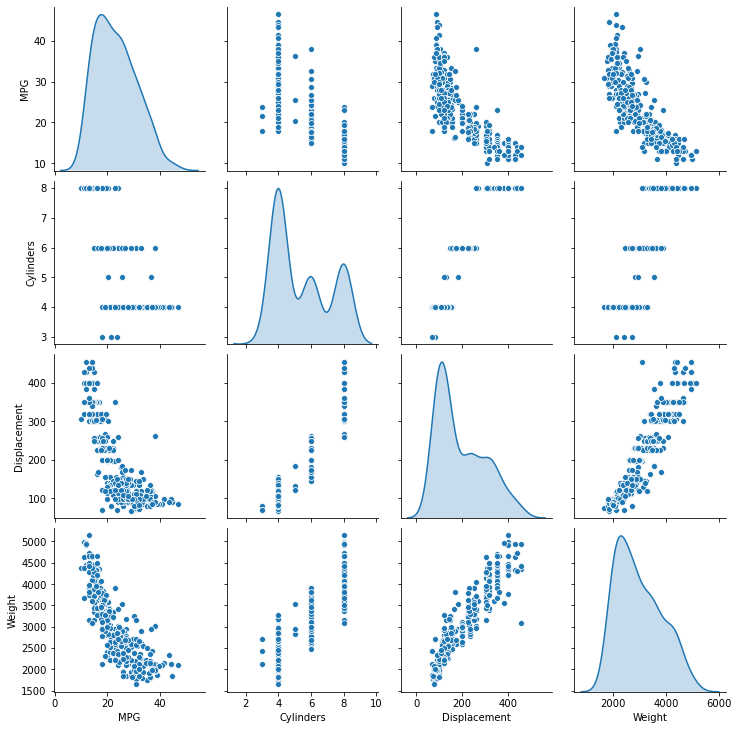

In [8]:
# 查看数据，联合概率分布
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
# 总体数据统计
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
# 分离训练数据中的特征标签
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [11]:
# 数据归一化，均值方差归一化
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 构建模型

In [15]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    return model  

In [16]:
# len(train_dataset.keys())
model = build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 model.predict 

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.21606827],
       [ 0.11793789],
       [-0.39717317],
       [ 0.24063018],
       [-0.19761167],
       [ 0.10776196],
       [-0.1950883 ],
       [-0.07674115],
       [ 0.05074718],
       [-0.31362668]], dtype=float32)

## 训练模型
对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [19]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1,
  callbacks=[PrintDot()])

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 1ms/sample - loss: 572.4992 - mae: 22.6808 - mse: 572.4993 - val_loss: 567.5960 - val_mae: 22.5133 - val_mse: 567.5960
Epoch 2/1000
251/251 [==============================] - 0s 132us/sample - loss: 525.1167 - mae: 21.6027 - mse: 525.1167 - val_loss: 519.9657 - val_mae: 21.4115 - val_mse: 519.9657
Epoch 3/1000
251/251 [==============================] - 0s 139us/sample - loss: 478.7009 - mae: 20.5081 - mse: 478.7009 - val_loss: 467.4649 - val_mae: 20.1590 - val_mse: 467.4649
Epoch 4/1000
251/251 [==============================] - 0s 127us/sample - loss: 427.4673 - mae: 19.2491 - mse: 427.4673 - val_loss: 409.8665 - val_mae: 18.6999 - val_mse: 409.8665
Epoch 5/1000
251/251 [==============================] - 0s 139us/sample - loss: 372.6082 - mae: 17.7899 - mse: 372.6082 - val_loss: 350.3522 - val_mae: 17.0629 - val_mse: 350.3522
Epoch 6/1000
251/251 [==============================] - 0

251/251 [==============================] - 0s 91us/sample - loss: 7.3692 - mae: 1.9416 - mse: 7.3692 - val_loss: 8.7013 - val_mae: 2.2083 - val_mse: 8.7013
Epoch 48/1000
251/251 [==============================] - 0s 107us/sample - loss: 7.3098 - mae: 1.9433 - mse: 7.3098 - val_loss: 8.6416 - val_mae: 2.2647 - val_mse: 8.6416
Epoch 49/1000
251/251 [==============================] - 0s 99us/sample - loss: 7.2342 - mae: 1.9045 - mse: 7.2342 - val_loss: 8.7311 - val_mae: 2.2207 - val_mse: 8.7311
Epoch 50/1000
251/251 [==============================] - 0s 87us/sample - loss: 7.3168 - mae: 1.9273 - mse: 7.3168 - val_loss: 8.7071 - val_mae: 2.2978 - val_mse: 8.7071
Epoch 51/1000
251/251 [==============================] - 0s 87us/sample - loss: 7.0691 - mae: 1.8931 - mse: 7.0691 - val_loss: 8.6705 - val_mae: 2.2295 - val_mse: 8.6705
Epoch 52/1000
251/251 [==============================] - 0s 95us/sample - loss: 7.2022 - mae: 1.9154 - mse: 7.2022 - val_loss: 8.7706 - val_mae: 2.1982 - val_mse: 

251/251 [==============================] - 0s 95us/sample - loss: 6.3239 - mae: 1.7616 - mse: 6.3239 - val_loss: 8.6490 - val_mae: 2.2265 - val_mse: 8.6490
Epoch 96/1000
251/251 [==============================] - 0s 87us/sample - loss: 6.1913 - mae: 1.7709 - mse: 6.1913 - val_loss: 8.6499 - val_mae: 2.2318 - val_mse: 8.6499
Epoch 97/1000
251/251 [==============================] - 0s 91us/sample - loss: 6.1781 - mae: 1.7503 - mse: 6.1781 - val_loss: 8.9190 - val_mae: 2.2018 - val_mse: 8.9190
Epoch 98/1000
251/251 [==============================] - 0s 95us/sample - loss: 6.3789 - mae: 1.8109 - mse: 6.3789 - val_loss: 8.8166 - val_mae: 2.2646 - val_mse: 8.8166
Epoch 99/1000
251/251 [==============================] - 0s 111us/sample - loss: 6.0366 - mae: 1.7213 - mse: 6.0366 - val_loss: 8.9169 - val_mae: 2.1925 - val_mse: 8.9169
Epoch 100/1000
251/251 [==============================] - 0s 139us/sample - loss: 6.1458 - mae: 1.7739 - mse: 6.1458 - val_loss: 8.7859 - val_mae: 2.2603 - val_mse

251/251 [==============================] - 0s 99us/sample - loss: 5.7848 - mae: 1.6749 - mse: 5.7848 - val_loss: 8.7991 - val_mae: 2.2828 - val_mse: 8.7991
Epoch 143/1000
251/251 [==============================] - 0s 95us/sample - loss: 5.8672 - mae: 1.7029 - mse: 5.8672 - val_loss: 9.0189 - val_mae: 2.3584 - val_mse: 9.0189
Epoch 144/1000
251/251 [==============================] - 0s 103us/sample - loss: 5.8405 - mae: 1.6729 - mse: 5.8405 - val_loss: 8.6457 - val_mae: 2.2221 - val_mse: 8.6457
Epoch 145/1000
251/251 [==============================] - 0s 107us/sample - loss: 5.8350 - mae: 1.6966 - mse: 5.8350 - val_loss: 8.7795 - val_mae: 2.2524 - val_mse: 8.7795
Epoch 146/1000
251/251 [==============================] - 0s 111us/sample - loss: 5.8038 - mae: 1.6845 - mse: 5.8038 - val_loss: 8.8666 - val_mae: 2.2153 - val_mse: 8.8666
Epoch 147/1000
251/251 [==============================] - 0s 126us/sample - loss: 5.7865 - mae: 1.6887 - mse: 5.7866 - val_loss: 8.7205 - val_mae: 2.2489 - v

251/251 [==============================] - 0s 124us/sample - loss: 5.4296 - mae: 1.5988 - mse: 5.4296 - val_loss: 8.9753 - val_mae: 2.2433 - val_mse: 8.9753
Epoch 190/1000
251/251 [==============================] - 0s 143us/sample - loss: 5.3960 - mae: 1.6146 - mse: 5.3960 - val_loss: 8.7985 - val_mae: 2.2646 - val_mse: 8.7985
Epoch 191/1000
251/251 [==============================] - 0s 107us/sample - loss: 5.5837 - mae: 1.6298 - mse: 5.5837 - val_loss: 8.7378 - val_mae: 2.3176 - val_mse: 8.7378
Epoch 192/1000
251/251 [==============================] - 0s 103us/sample - loss: 5.3398 - mae: 1.5863 - mse: 5.3398 - val_loss: 8.7948 - val_mae: 2.2401 - val_mse: 8.7948
Epoch 193/1000
251/251 [==============================] - 0s 95us/sample - loss: 5.3662 - mae: 1.5989 - mse: 5.3662 - val_loss: 8.7120 - val_mae: 2.2961 - val_mse: 8.7120
Epoch 194/1000
251/251 [==============================] - 0s 95us/sample - loss: 5.6689 - mae: 1.6466 - mse: 5.6689 - val_loss: 9.2166 - val_mae: 2.3031 - v

251/251 [==============================] - 0s 107us/sample - loss: 5.2816 - mae: 1.5840 - mse: 5.2816 - val_loss: 8.6781 - val_mae: 2.2917 - val_mse: 8.6781
Epoch 237/1000
251/251 [==============================] - 0s 107us/sample - loss: 5.1739 - mae: 1.5463 - mse: 5.1739 - val_loss: 8.7322 - val_mae: 2.2868 - val_mse: 8.7322
Epoch 238/1000
251/251 [==============================] - 0s 103us/sample - loss: 5.1058 - mae: 1.5617 - mse: 5.1058 - val_loss: 8.6417 - val_mae: 2.2344 - val_mse: 8.6417
Epoch 239/1000
251/251 [==============================] - 0s 98us/sample - loss: 5.1289 - mae: 1.5533 - mse: 5.1289 - val_loss: 9.0141 - val_mae: 2.2624 - val_mse: 9.0141
Epoch 240/1000
251/251 [==============================] - 0s 99us/sample - loss: 5.2309 - mae: 1.6046 - mse: 5.2309 - val_loss: 8.7305 - val_mae: 2.3000 - val_mse: 8.7305
Epoch 241/1000
251/251 [==============================] - 0s 99us/sample - loss: 5.1252 - mae: 1.5694 - mse: 5.1252 - val_loss: 8.6334 - val_mae: 2.2619 - va

Epoch 284/1000
251/251 [==============================] - 0s 91us/sample - loss: 4.9064 - mae: 1.5202 - mse: 4.9064 - val_loss: 8.7018 - val_mae: 2.2611 - val_mse: 8.7018
Epoch 285/1000
251/251 [==============================] - 0s 103us/sample - loss: 4.8087 - mae: 1.5054 - mse: 4.8087 - val_loss: 9.0928 - val_mae: 2.3752 - val_mse: 9.0928
Epoch 286/1000
251/251 [==============================] - 0s 95us/sample - loss: 4.8913 - mae: 1.4921 - mse: 4.8913 - val_loss: 8.8606 - val_mae: 2.2604 - val_mse: 8.8606
Epoch 287/1000
251/251 [==============================] - 0s 221us/sample - loss: 5.1988 - mae: 1.5446 - mse: 5.1988 - val_loss: 8.6772 - val_mae: 2.2959 - val_mse: 8.6772
Epoch 288/1000
251/251 [==============================] - 0s 183us/sample - loss: 4.8799 - mae: 1.5066 - mse: 4.8799 - val_loss: 8.7809 - val_mae: 2.3412 - val_mse: 8.7809
Epoch 289/1000
251/251 [==============================] - 0s 159us/sample - loss: 4.8565 - mae: 1.5234 - mse: 4.8565 - val_loss: 8.7271 - val_

251/251 [==============================] - 0s 99us/sample - loss: 4.4330 - mae: 1.4208 - mse: 4.4330 - val_loss: 9.3595 - val_mae: 2.2939 - val_mse: 9.3595
Epoch 332/1000
251/251 [==============================] - 0s 96us/sample - loss: 4.6053 - mae: 1.4471 - mse: 4.6053 - val_loss: 9.1542 - val_mae: 2.2589 - val_mse: 9.1542
Epoch 333/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.7698 - mae: 1.4807 - mse: 4.7698 - val_loss: 8.7053 - val_mae: 2.2823 - val_mse: 8.7053
Epoch 334/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.7118 - mae: 1.4531 - mse: 4.7118 - val_loss: 8.7482 - val_mae: 2.2640 - val_mse: 8.7482
Epoch 335/1000
251/251 [==============================] - 0s 107us/sample - loss: 4.6982 - mae: 1.4361 - mse: 4.6982 - val_loss: 9.0628 - val_mae: 2.2668 - val_mse: 9.0628
Epoch 336/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.6061 - mae: 1.4509 - mse: 4.6061 - val_loss: 8.9786 - val_mae: 2.3097 - val_

Epoch 379/1000
251/251 [==============================] - 0s 111us/sample - loss: 4.3825 - mae: 1.4121 - mse: 4.3825 - val_loss: 8.8195 - val_mae: 2.3245 - val_mse: 8.8195
Epoch 380/1000
251/251 [==============================] - 0s 103us/sample - loss: 4.4709 - mae: 1.4556 - mse: 4.4709 - val_loss: 8.8165 - val_mae: 2.3226 - val_mse: 8.8165
Epoch 381/1000
251/251 [==============================] - 0s 118us/sample - loss: 4.4129 - mae: 1.4193 - mse: 4.4129 - val_loss: 8.9934 - val_mae: 2.3478 - val_mse: 8.9934
Epoch 382/1000
251/251 [==============================] - 0s 111us/sample - loss: 4.3236 - mae: 1.4000 - mse: 4.3236 - val_loss: 8.8620 - val_mae: 2.3083 - val_mse: 8.8621
Epoch 383/1000
251/251 [==============================] - 0s 115us/sample - loss: 4.5373 - mae: 1.4095 - mse: 4.5373 - val_loss: 8.7082 - val_mae: 2.2841 - val_mse: 8.7082
Epoch 384/1000
251/251 [==============================] - 0s 111us/sample - loss: 4.3802 - mae: 1.3925 - mse: 4.3802 - val_loss: 8.7096 - va

Epoch 426/1000
251/251 [==============================] - 0s 115us/sample - loss: 4.1564 - mae: 1.3724 - mse: 4.1564 - val_loss: 8.7776 - val_mae: 2.2872 - val_mse: 8.7776
Epoch 427/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.1672 - mae: 1.3729 - mse: 4.1672 - val_loss: 8.9030 - val_mae: 2.2789 - val_mse: 8.9030
Epoch 428/1000
251/251 [==============================] - 0s 115us/sample - loss: 4.2427 - mae: 1.4128 - mse: 4.2427 - val_loss: 9.2276 - val_mae: 2.3698 - val_mse: 9.2276
Epoch 429/1000
251/251 [==============================] - 0s 178us/sample - loss: 4.1249 - mae: 1.3687 - mse: 4.1249 - val_loss: 9.0219 - val_mae: 2.3506 - val_mse: 9.0219
Epoch 430/1000
251/251 [==============================] - 0s 179us/sample - loss: 4.2309 - mae: 1.3756 - mse: 4.2309 - val_loss: 9.0225 - val_mae: 2.3186 - val_mse: 9.0225
Epoch 431/1000
251/251 [==============================] - 0s 175us/sample - loss: 4.1715 - mae: 1.3725 - mse: 4.1715 - val_loss: 8.9405 - val

Epoch 474/1000
251/251 [==============================] - 0s 103us/sample - loss: 3.9690 - mae: 1.3141 - mse: 3.9690 - val_loss: 8.8933 - val_mae: 2.3270 - val_mse: 8.8933
Epoch 475/1000
251/251 [==============================] - 0s 95us/sample - loss: 3.8414 - mae: 1.2883 - mse: 3.8414 - val_loss: 9.3255 - val_mae: 2.3038 - val_mse: 9.3255
Epoch 476/1000
251/251 [==============================] - 0s 99us/sample - loss: 4.1354 - mae: 1.3562 - mse: 4.1354 - val_loss: 9.2394 - val_mae: 2.3524 - val_mse: 9.2394
Epoch 477/1000
251/251 [==============================] - 0s 108us/sample - loss: 4.0721 - mae: 1.3544 - mse: 4.0721 - val_loss: 9.2219 - val_mae: 2.3567 - val_mse: 9.2219
Epoch 478/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.9818 - mae: 1.3327 - mse: 3.9818 - val_loss: 8.7683 - val_mae: 2.3045 - val_mse: 8.7683
Epoch 479/1000
251/251 [==============================] - 0s 91us/sample - loss: 3.9524 - mae: 1.3208 - mse: 3.9524 - val_loss: 8.6743 - val_ma

251/251 [==============================] - 0s 99us/sample - loss: 3.8551 - mae: 1.3105 - mse: 3.8551 - val_loss: 8.6536 - val_mae: 2.2862 - val_mse: 8.6536
Epoch 522/1000
251/251 [==============================] - 0s 111us/sample - loss: 3.7459 - mae: 1.2778 - mse: 3.7459 - val_loss: 8.5891 - val_mae: 2.2842 - val_mse: 8.5891
Epoch 523/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.9857 - mae: 1.3281 - mse: 3.9857 - val_loss: 8.7486 - val_mae: 2.2967 - val_mse: 8.7486
Epoch 524/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.7425 - mae: 1.3016 - mse: 3.7425 - val_loss: 9.0298 - val_mae: 2.3364 - val_mse: 9.0298
Epoch 525/1000
251/251 [==============================] - 0s 111us/sample - loss: 3.9082 - mae: 1.2906 - mse: 3.9082 - val_loss: 8.7690 - val_mae: 2.2672 - val_mse: 8.7690
Epoch 526/1000
251/251 [==============================] - 0s 83us/sample - loss: 3.7530 - mae: 1.2980 - mse: 3.7530 - val_loss: 8.5566 - val_mae: 2.2693 - va

Epoch 569/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.5672 - mae: 1.2409 - mse: 3.5672 - val_loss: 8.7202 - val_mae: 2.2605 - val_mse: 8.7202
Epoch 570/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.9220 - mae: 1.3099 - mse: 3.9220 - val_loss: 8.4347 - val_mae: 2.2082 - val_mse: 8.4347
Epoch 571/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.6418 - mae: 1.2564 - mse: 3.6418 - val_loss: 8.7388 - val_mae: 2.2534 - val_mse: 8.7388
Epoch 572/1000
251/251 [==============================] - 0s 95us/sample - loss: 3.5373 - mae: 1.2267 - mse: 3.5373 - val_loss: 8.8131 - val_mae: 2.2457 - val_mse: 8.8131
Epoch 573/1000
251/251 [==============================] - 0s 95us/sample - loss: 3.5716 - mae: 1.2500 - mse: 3.5716 - val_loss: 8.6060 - val_mae: 2.2210 - val_mse: 8.6060
Epoch 574/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.7913 - mae: 1.2734 - mse: 3.7913 - val_loss: 8.7743 - val_mae

251/251 [==============================] - 0s 127us/sample - loss: 3.4475 - mae: 1.2311 - mse: 3.4475 - val_loss: 8.5774 - val_mae: 2.1886 - val_mse: 8.5774
Epoch 617/1000
251/251 [==============================] - 0s 122us/sample - loss: 3.5095 - mae: 1.2348 - mse: 3.5095 - val_loss: 9.0817 - val_mae: 2.2863 - val_mse: 9.0817
Epoch 618/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.5578 - mae: 1.2448 - mse: 3.5578 - val_loss: 9.4446 - val_mae: 2.3313 - val_mse: 9.4446
Epoch 619/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.6419 - mae: 1.2302 - mse: 3.6419 - val_loss: 8.9765 - val_mae: 2.2946 - val_mse: 8.9765
Epoch 620/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.8032 - mae: 1.2723 - mse: 3.8032 - val_loss: 8.3018 - val_mae: 2.1919 - val_mse: 8.3018
Epoch 621/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.4368 - mae: 1.2148 - mse: 3.4368 - val_loss: 8.5745 - val_mae: 2.2207 - 

251/251 [==============================] - 0s 115us/sample - loss: 3.3414 - mae: 1.1883 - mse: 3.3414 - val_loss: 8.6444 - val_mae: 2.2156 - val_mse: 8.6444
Epoch 664/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.2638 - mae: 1.2029 - mse: 3.2638 - val_loss: 8.5901 - val_mae: 2.2592 - val_mse: 8.5901
Epoch 665/1000
251/251 [==============================] - 0s 135us/sample - loss: 3.6056 - mae: 1.2509 - mse: 3.6056 - val_loss: 8.7047 - val_mae: 2.2178 - val_mse: 8.7047
Epoch 666/1000
251/251 [==============================] - 0s 96us/sample - loss: 3.3670 - mae: 1.2222 - mse: 3.3670 - val_loss: 8.6292 - val_mae: 2.2005 - val_mse: 8.6292
Epoch 667/1000
251/251 [==============================] - 0s 91us/sample - loss: 3.5106 - mae: 1.2331 - mse: 3.5106 - val_loss: 8.7191 - val_mae: 2.2368 - val_mse: 8.7191
Epoch 668/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.3849 - mae: 1.2115 - mse: 3.3849 - val_loss: 8.6582 - val_mae: 2.2139 - val

251/251 [==============================] - 0s 95us/sample - loss: 3.2812 - mae: 1.1854 - mse: 3.2812 - val_loss: 8.9881 - val_mae: 2.2095 - val_mse: 8.9881
Epoch 711/1000
251/251 [==============================] - 0s 115us/sample - loss: 3.2422 - mae: 1.1951 - mse: 3.2422 - val_loss: 8.6533 - val_mae: 2.2093 - val_mse: 8.6533
Epoch 712/1000
251/251 [==============================] - 0s 294us/sample - loss: 3.3348 - mae: 1.2021 - mse: 3.3348 - val_loss: 8.7760 - val_mae: 2.2329 - val_mse: 8.7760
Epoch 713/1000
251/251 [==============================] - 0s 163us/sample - loss: 3.3673 - mae: 1.1973 - mse: 3.3673 - val_loss: 9.0559 - val_mae: 2.2434 - val_mse: 9.0559
Epoch 714/1000
251/251 [==============================] - 0s 103us/sample - loss: 3.0853 - mae: 1.1647 - mse: 3.0853 - val_loss: 8.7179 - val_mae: 2.1915 - val_mse: 8.7179
Epoch 715/1000
251/251 [==============================] - 0s 91us/sample - loss: 3.2652 - mae: 1.1711 - mse: 3.2652 - val_loss: 8.6946 - val_mae: 2.1927 - v

Epoch 758/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.1671 - mae: 1.1542 - mse: 3.1671 - val_loss: 9.2318 - val_mae: 2.2515 - val_mse: 9.2318
Epoch 759/1000
251/251 [==============================] - 0s 91us/sample - loss: 3.0879 - mae: 1.1330 - mse: 3.0879 - val_loss: 8.6280 - val_mae: 2.2186 - val_mse: 8.6280
Epoch 760/1000
251/251 [==============================] - 0s 99us/sample - loss: 3.1028 - mae: 1.1437 - mse: 3.1028 - val_loss: 10.1314 - val_mae: 2.3506 - val_mse: 10.1314
Epoch 761/1000
251/251 [==============================] - 0s 131us/sample - loss: 3.1962 - mae: 1.1248 - mse: 3.1962 - val_loss: 8.8738 - val_mae: 2.2181 - val_mse: 8.8738
Epoch 762/1000
251/251 [==============================] - 0s 179us/sample - loss: 3.0867 - mae: 1.1356 - mse: 3.0867 - val_loss: 8.5782 - val_mae: 2.1887 - val_mse: 8.5782
Epoch 763/1000
251/251 [==============================] - 0s 191us/sample - loss: 3.1269 - mae: 1.1174 - mse: 3.1269 - val_loss: 8.9387 - va

251/251 [==============================] - 0s 111us/sample - loss: 3.0042 - mae: 1.1186 - mse: 3.0042 - val_loss: 9.2963 - val_mae: 2.2482 - val_mse: 9.2963
Epoch 806/1000
251/251 [==============================] - 0s 119us/sample - loss: 3.0945 - mae: 1.1244 - mse: 3.0945 - val_loss: 8.7751 - val_mae: 2.1890 - val_mse: 8.7751
Epoch 807/1000
251/251 [==============================] - 0s 111us/sample - loss: 3.0167 - mae: 1.0996 - mse: 3.0167 - val_loss: 9.7985 - val_mae: 2.2850 - val_mse: 9.7985
Epoch 808/1000
251/251 [==============================] - 0s 103us/sample - loss: 3.0822 - mae: 1.1226 - mse: 3.0822 - val_loss: 9.4191 - val_mae: 2.2681 - val_mse: 9.4191
Epoch 809/1000
251/251 [==============================] - 0s 111us/sample - loss: 3.1286 - mae: 1.1220 - mse: 3.1286 - val_loss: 9.0636 - val_mae: 2.2431 - val_mse: 9.0636
Epoch 810/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.0146 - mae: 1.1260 - mse: 3.0146 - val_loss: 10.3688 - val_mae: 2.4020 

Epoch 853/1000
251/251 [==============================] - 0s 119us/sample - loss: 2.8153 - mae: 1.0804 - mse: 2.8153 - val_loss: 9.8480 - val_mae: 2.3348 - val_mse: 9.8480
Epoch 854/1000
251/251 [==============================] - 0s 123us/sample - loss: 3.1682 - mae: 1.1591 - mse: 3.1682 - val_loss: 9.3830 - val_mae: 2.2320 - val_mse: 9.3830
Epoch 855/1000
251/251 [==============================] - 0s 111us/sample - loss: 2.8150 - mae: 1.0527 - mse: 2.8150 - val_loss: 10.4782 - val_mae: 2.4047 - val_mse: 10.4782
Epoch 856/1000
251/251 [==============================] - 0s 107us/sample - loss: 3.0538 - mae: 1.1186 - mse: 3.0538 - val_loss: 9.5405 - val_mae: 2.2474 - val_mse: 9.5405
Epoch 857/1000
251/251 [==============================] - 0s 122us/sample - loss: 2.8541 - mae: 1.0884 - mse: 2.8541 - val_loss: 9.6646 - val_mae: 2.3100 - val_mse: 9.6646
Epoch 858/1000
251/251 [==============================] - 0s 115us/sample - loss: 3.1334 - mae: 1.1309 - mse: 3.1334 - val_loss: 9.9188 - 

251/251 [==============================] - 0s 103us/sample - loss: 2.9251 - mae: 1.1143 - mse: 2.9251 - val_loss: 9.4842 - val_mae: 2.2463 - val_mse: 9.4841
Epoch 901/1000
251/251 [==============================] - 0s 125us/sample - loss: 2.8032 - mae: 1.0887 - mse: 2.8032 - val_loss: 10.2256 - val_mae: 2.3995 - val_mse: 10.2256
Epoch 902/1000
251/251 [==============================] - 0s 111us/sample - loss: 2.8667 - mae: 1.0744 - mse: 2.8667 - val_loss: 9.2184 - val_mae: 2.2449 - val_mse: 9.2184
Epoch 903/1000
251/251 [==============================] - 0s 107us/sample - loss: 2.9528 - mae: 1.0955 - mse: 2.9528 - val_loss: 9.2339 - val_mae: 2.2302 - val_mse: 9.2339
Epoch 904/1000
251/251 [==============================] - 0s 110us/sample - loss: 2.8730 - mae: 1.0966 - mse: 2.8730 - val_loss: 10.2104 - val_mae: 2.3873 - val_mse: 10.2104
Epoch 905/1000
251/251 [==============================] - 0s 107us/sample - loss: 2.9067 - mae: 1.0702 - mse: 2.9067 - val_loss: 9.5708 - val_mae: 2.27

251/251 [==============================] - 0s 147us/sample - loss: 2.6806 - mae: 1.0229 - mse: 2.6806 - val_loss: 9.6417 - val_mae: 2.2683 - val_mse: 9.6417
Epoch 948/1000
251/251 [==============================] - 0s 127us/sample - loss: 2.7429 - mae: 1.0702 - mse: 2.7429 - val_loss: 10.9411 - val_mae: 2.5304 - val_mse: 10.9411
Epoch 949/1000
251/251 [==============================] - 0s 99us/sample - loss: 2.8976 - mae: 1.0623 - mse: 2.8976 - val_loss: 9.7429 - val_mae: 2.3309 - val_mse: 9.7429
Epoch 950/1000
251/251 [==============================] - 0s 95us/sample - loss: 2.7003 - mae: 1.0291 - mse: 2.7003 - val_loss: 9.6063 - val_mae: 2.2432 - val_mse: 9.6063
Epoch 951/1000
251/251 [==============================] - 0s 91us/sample - loss: 2.7860 - mae: 1.0422 - mse: 2.7860 - val_loss: 9.0512 - val_mae: 2.1640 - val_mse: 9.0512
Epoch 952/1000
251/251 [==============================] - 0s 92us/sample - loss: 2.7189 - mae: 1.0279 - mse: 2.7189 - val_loss: 9.6572 - val_mae: 2.2533 - v

Epoch 995/1000
251/251 [==============================] - 0s 87us/sample - loss: 2.8001 - mae: 1.0546 - mse: 2.8001 - val_loss: 10.2517 - val_mae: 2.4051 - val_mse: 10.2517
Epoch 996/1000
251/251 [==============================] - 0s 91us/sample - loss: 2.6635 - mae: 1.0386 - mse: 2.6635 - val_loss: 9.5631 - val_mae: 2.3161 - val_mse: 9.5631
Epoch 997/1000
251/251 [==============================] - 0s 95us/sample - loss: 2.7046 - mae: 1.0544 - mse: 2.7046 - val_loss: 9.3589 - val_mae: 2.1986 - val_mse: 9.3589
Epoch 998/1000
251/251 [==============================] - 0s 95us/sample - loss: 2.7464 - mae: 1.0479 - mse: 2.7464 - val_loss: 10.4475 - val_mae: 2.4184 - val_mse: 10.4475
Epoch 999/1000
251/251 [==============================] - 0s 87us/sample - loss: 2.5464 - mae: 1.0128 - mse: 2.5464 - val_loss: 10.2683 - val_mae: 2.4143 - val_mse: 10.2683
Epoch 1000/1000
251/251 [==============================] - 0s 95us/sample - loss: 2.8097 - mae: 1.0400 - mse: 2.8097 - val_loss: 10.0178 - 

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.663490,1.038620,2.663490,9.563055,2.316067,9.563056,995
996,2.704607,1.054401,2.704607,9.358916,2.198556,9.358915,996
997,2.746408,1.047860,2.746408,10.447456,2.418447,10.447455,997
998,2.546426,1.012812,2.546426,10.268332,2.414259,10.268332,998
999,2.809666,1.040025,2.809665,10.017781,2.423690,10.017781,999


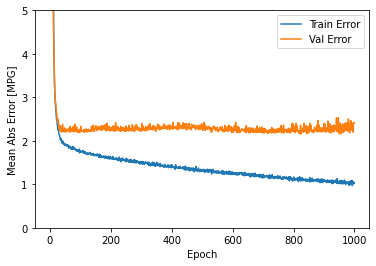

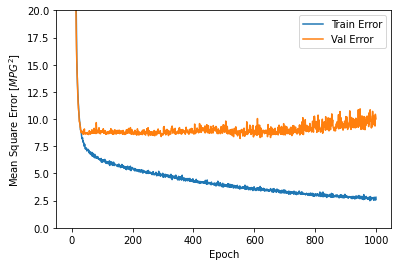

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 871us/sample - loss: 571.6372 - mae: 22.6468 - mse: 571.6373 - val_loss: 564.5944 - val_mae: 22.4728 - val_mse: 564.5944
Epoch 2/1000
251/251 [==============================] - 0s 127us/sample - loss: 523.1625 - mae: 21.5939 - mse: 523.1625 - val_loss: 512.7616 - val_mae: 21.3348 - val_mse: 512.7616
Epoch 3/1000
251/251 [==============================] - 0s 139us/sample - loss: 473.8929 - mae: 20.4741 - mse: 473.8929 - val_loss: 455.5761 - val_mae: 20.0141 - val_mse: 455.5761
Epoch 4/1000
251/251 [==============================] - 0s 127us/sample - loss: 419.2900 - mae: 19.1729 - mse: 419.2900 - val_loss: 392.5387 - val_mae: 18.4694 - val_mse: 392.5387
Epoch 5/1000
251/251 [==============================] - 0s 119us/sample - loss: 358.3724 - mae: 17.6309 - mse: 358.3724 - val_loss: 323.7844 - val_mae: 16.6470 - val_mse: 323.7844
Epoch 6/1000
251/251 [==============================] -

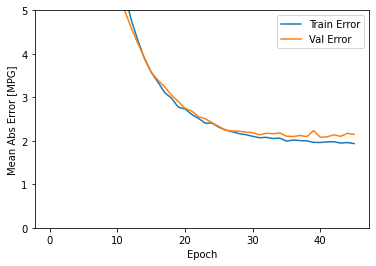

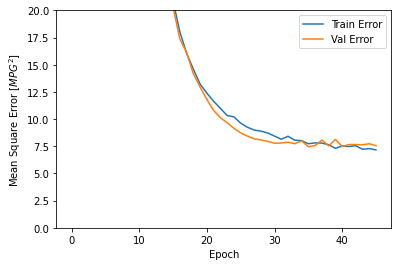

In [24]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [25]:
# 测试集
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6340 - mae: 1.7964 - mse: 5.6340
Testing set Mean Abs Error:  1.80 MPG


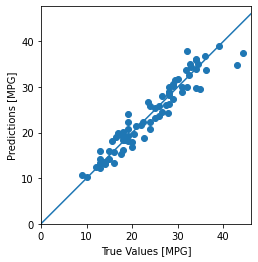

In [26]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


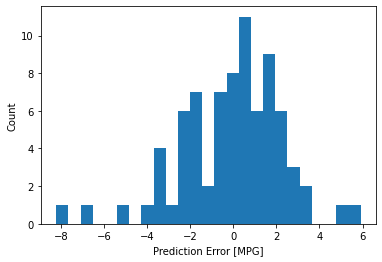

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 结论
误差分析

- 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
- 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
- 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
- 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
- 早期停止是一种防止过度拟合的有效技术

# Model  显示精度

In [29]:
def build_model_2():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['accuracy'])
    
    return model  

In [30]:
model2 = build_model_2()
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Train on 251 samples, validate on 63 samples
Epoch 1/100
251/251 [==============================] - 0s 135us/sample - loss: 7.2099 - mae: 1.9507 - mse: 7.2099 - val_loss: 7.3720 - val_mae: 2.0968 - val_mse: 7.3720
Epoch 2/100
251/251 [==============================] - 0s 171us/sample - loss: 7.2333 - mae: 1.9230 - mse: 7.2333 - val_loss: 7.5717 - val_mae: 2.1130 - val_mse: 7.5717
Epoch 3/100
251/251 [==============================] - 0s 135us/sample - loss: 7.1565 - mae: 1.9303 - mse: 7.1565 - val_loss: 7.7347 - val_mae: 2.1246 - val_mse: 7.7347
Epoch 4/100
251/251 [==============================] - 0s 131us/sample - loss: 7.0409 - mae: 1.9454 - mse: 7.0409 - val_loss: 7.6376 - val_mae: 2.1316 - val_mse: 7.6376
Epoch 5/100
251/251 [==============================] - 0s 135us/sample - loss: 6.9713 - mae: 1.8972 - mse: 6.9713 - val_loss: 7.6616 - val_mae: 2.1333 - val_mse: 7.6616
Epoch 6/100
251/251 [==============================] - 0s 99us/sample - loss: 6.9346 - mae: 1.8978 - mse: 6.93

Epoch 49/100
251/251 [==============================] - 0s 103us/sample - loss: 5.9803 - mae: 1.7312 - mse: 5.9803 - val_loss: 7.7700 - val_mae: 2.1559 - val_mse: 7.7700
Epoch 50/100
251/251 [==============================] - 0s 83us/sample - loss: 5.9155 - mae: 1.7249 - mse: 5.9155 - val_loss: 7.7008 - val_mae: 2.0952 - val_mse: 7.7008
Epoch 51/100
251/251 [==============================] - 0s 80us/sample - loss: 5.9322 - mae: 1.7227 - mse: 5.9322 - val_loss: 7.6810 - val_mae: 2.1056 - val_mse: 7.6810
Epoch 52/100
251/251 [==============================] - 0s 79us/sample - loss: 6.0905 - mae: 1.7416 - mse: 6.0905 - val_loss: 7.6800 - val_mae: 2.1176 - val_mse: 7.6800
Epoch 53/100
251/251 [==============================] - 0s 83us/sample - loss: 5.9793 - mae: 1.7327 - mse: 5.9793 - val_loss: 7.6141 - val_mae: 2.1034 - val_mse: 7.6141
Epoch 54/100
251/251 [==============================] - 0s 91us/sample - loss: 5.8275 - mae: 1.7162 - mse: 5.8275 - val_loss: 7.9155 - val_mae: 2.1105 - v

251/251 [==============================] - 0s 115us/sample - loss: 5.5355 - mae: 1.6367 - mse: 5.5355 - val_loss: 7.9244 - val_mae: 2.1714 - val_mse: 7.9244
Epoch 98/100
251/251 [==============================] - 0s 111us/sample - loss: 5.4850 - mae: 1.6257 - mse: 5.4850 - val_loss: 8.2315 - val_mae: 2.0860 - val_mse: 8.2315
Epoch 99/100
251/251 [==============================] - 0s 107us/sample - loss: 5.4680 - mae: 1.6380 - mse: 5.4680 - val_loss: 8.0849 - val_mae: 2.1536 - val_mse: 8.0849
Epoch 100/100
251/251 [==============================] - 0s 103us/sample - loss: 5.3773 - mae: 1.6092 - mse: 5.3773 - val_loss: 7.8902 - val_mae: 2.1208 - val_mse: 7.8902
